In [1]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt

def load_multiline_json_objects(filepath):
    """
    Load multiple JSON objects from a file with improved error handling
    """
    objects = []
    current_object = ""
    brace_count = 0
    
    with open(filepath, 'r') as f:
        for line in f:
            current_object += line
            brace_count += line.count('{') - line.count('}')
            
            if brace_count == 0 and current_object.strip():
                try:
                    obj = json.loads(current_object)
                    objects.append(obj)
                    current_object = ""
                except json.JSONDecodeError as e:
                    print(f"Warning: Skipping malformed JSON object: {e}")
                    current_object = ""
    
    return objects

def plot_grid_results(results_dir):
    """
    Load all result files in the given directory and produce a grid plot.
    
    The grid is arranged as:
      - Columns: different learning rates.
      - Rows: different depths.
      
    Each subplot plots the test error vs. training set size (both on log scale) for different widths.
    """
    # Find all result files (we assume files starting with "results_" and ending with ".jsonl")
    result_files = [
        os.path.join(results_dir, f)
        for f in os.listdir(results_dir)
        if f.startswith("results_") and f.endswith(".jsonl")
    ]
    
    if not result_files:
        print("No results files found in the specified folder.")
        return

    results = []
    for filepath in result_files:
        # Try reading the file as a JSONL file first
        try:
            with open(filepath, "r") as f:
                for line in f:
                    # Skip empty lines
                    if not line.strip():
                        continue
                    # Try to load each line
                    obj = json.loads(line)
                    results.append(obj)
        except json.JSONDecodeError:
            # If that fails, fall back to multi-line JSON extraction
            print(f"Falling back to multi-line JSON extraction for {filepath}")
            objs = load_multiline_json_objects(filepath)
            results.extend(objs)

    # Remove any entries that are not dictionaries.
    valid_results = [r for r in results if isinstance(r, dict)]
    if not valid_results:
        print("No valid results were loaded.")
        return

    # Group results by (depth, learning_rate) and then by hidden_size.
    grouped = {}  # key: (depth, learning_rate) -> value: dict {hidden_size: list of (n_train, test_error)}
    for res in valid_results:
        depth = res.get("depth")
        lr = res.get("learning_rate")
        width = res.get("hidden_size")
        n_train = res.get("n_train")
        test_error = res.get("test_error")
        if None in (depth, lr, width, n_train, test_error):
            continue

        key = (depth, lr)
        if key not in grouped:
            grouped[key] = {}
        if width not in grouped[key]:
            grouped[key][width] = []
        grouped[key][width].append((n_train, test_error))
    
    # Determine unique depths, learning rates, and widths.
    unique_depths = sorted({key[0] for key in grouped.keys()})
    unique_lrs = sorted({key[1] for key in grouped.keys()})
    
    all_widths = set()
    for group in grouped.values():
        all_widths.update(group.keys())
    unique_widths = sorted(all_widths)
    
    # Create a blue colormap for different widths.
    cmap = plt.cm.Blues
    colors = {}
    n_widths = len(unique_widths)
    for i, width in enumerate(unique_widths):
        norm_val = 0.4 + 0.4 * (i / (n_widths - 1)) if n_widths > 1 else 0.6
        colors[width] = cmap(norm_val)
    
    # Create a grid of subplots.
    n_rows = len(unique_depths)
    n_cols = len(unique_lrs)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)
    
    for i, depth in enumerate(unique_depths):
        for j, lr in enumerate(unique_lrs):
            ax = axes[i][j]
            key = (depth, lr)
            if key not in grouped:
                ax.set_visible(False)
                continue
                
            for width, data_points in grouped[key].items():
                # Aggregate points by training set size.
                agg = {}
                for nt, te in data_points:
                    agg.setdefault(nt, []).append(te)
                n_trains_sorted = sorted(agg.keys())
                avg_test_errors = [np.mean(agg[nt]) for nt in n_trains_sorted]
                
                ax.plot(
                    n_trains_sorted,
                    avg_test_errors,
                    marker='o',
                    color=colors[width],
                    label=f"width {width}"
                )
                
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_title(f"depth = {depth}, lr = {lr}")
            ax.set_xlabel("Training set size")
            ax.set_ylabel("Test error")
            ax.legend(fontsize='small', loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage:
results_folder_path = "/mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=0_grid"
plot_grid_results(results_folder_path)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=0_grid'

Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=0_grid/results_20250210_053802_rank3.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=0_grid/results_20250210_053802_rank2.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=0_grid/results_20250210_053802_rank1.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=0_grid/results_20250210_053802_rank0.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=1_grid/results_20250210_054108_rank2.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=1_grid/results_20250210_05410

/tmp/ipykernel_2797261/2404330889.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')
/tmp/ipykernel_2797261/2404330889.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgb = plt.cm.get_cmap(base_color)(norm_val)[:3]


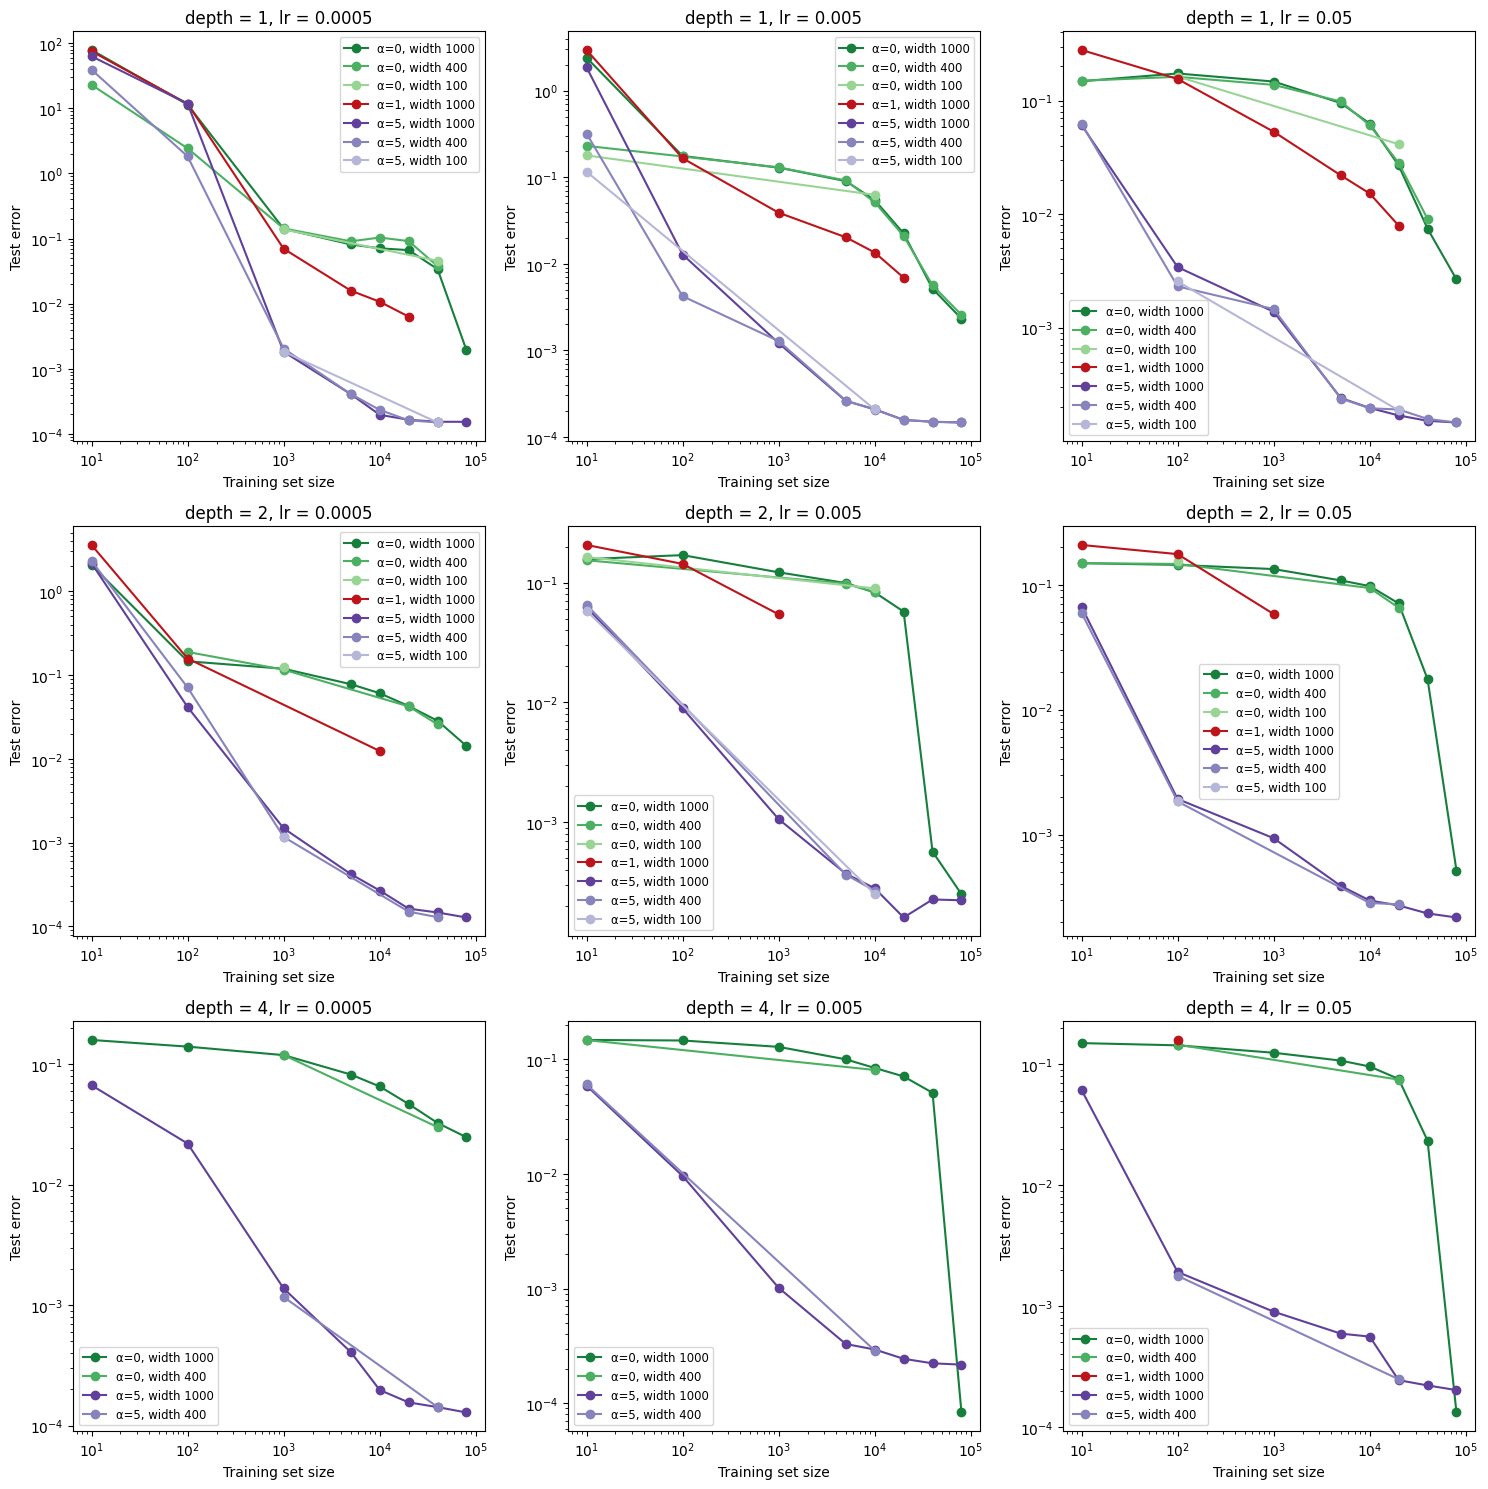

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_multiline_json_objects(filepath):
    """
    Load multiple JSON objects from a file with improved error handling
    """
    objects = []
    current_object = ""
    brace_count = 0
    
    with open(filepath, 'r') as f:
        for line in f:
            current_object += line
            brace_count += line.count('{') - line.count('}')
            
            if brace_count == 0 and current_object.strip():
                try:
                    obj = json.loads(current_object)
                    objects.append(obj)
                    current_object = ""
                except json.JSONDecodeError as e:
                    print(f"Warning: Skipping malformed JSON object: {e}")
                    current_object = ""
    
    return objects

def plot_multiple_alpha_results(results_dirs, alpha_names, alpha_colors):
    """
    Load and plot results from multiple directories with different alpha values.
    
    Args:
        results_dirs: List of directory paths containing result files
        alpha_names: List of names for each alpha value (e.g., ['α=0', 'α=1'])
        alpha_colors: List of base colors for each alpha value
    """
    # Store results for each alpha value
    all_results = []
    
    for results_dir in results_dirs:
        result_files = [
            os.path.join(results_dir, f)
            for f in os.listdir(results_dir)
            if f.startswith("results_") and f.endswith(".jsonl")
        ]
        
        results = []
        for filepath in result_files:
            try:
                with open(filepath, "r") as f:
                    for line in f:
                        if not line.strip():
                            continue
                        obj = json.loads(line)
                        results.append(obj)
            except json.JSONDecodeError:
                print(f"Falling back to multi-line JSON extraction for {filepath}")
                objs = load_multiline_json_objects(filepath)
                results.extend(objs)
        
        all_results.append([r for r in results if isinstance(r, dict)])

    # Create grouped data for each alpha value
    all_grouped = []
    for results in all_results:
        grouped = {}
        for res in results:
            depth = res.get("depth")
            lr = res.get("learning_rate")
            width = res.get("hidden_size")
            n_train = res.get("n_train")
            test_error = res.get("test_error")
            if None in (depth, lr, width, n_train, test_error):
                continue

            key = (depth, lr)
            if key not in grouped:
                grouped[key] = {}
            if width not in grouped[key]:
                grouped[key][width] = []
            grouped[key][width].append((n_train, test_error))
        all_grouped.append(grouped)

    # Get unique parameters across all results
    unique_depths = sorted(set().union(*[set(key[0] for key in group.keys()) for group in all_grouped]))
    unique_lrs = sorted(set().union(*[set(key[1] for key in group.keys()) for group in all_grouped]))
    
    all_widths = set()
    for grouped in all_grouped:
        for group in grouped.values():
            all_widths.update(group.keys())
    unique_widths = sorted(all_widths)

    # Create color maps for different widths within each alpha group
    n_widths = len(unique_widths)
    width_colors = {}
    for alpha_idx, base_color in enumerate(alpha_colors):
        cmap = plt.cm.get_cmap('Blues')
        width_colors[alpha_idx] = {}
        for i, width in enumerate(unique_widths):
            norm_val = 0.4 + 0.4 * (i / (n_widths - 1)) if n_widths > 1 else 0.6
            rgb = plt.cm.get_cmap(base_color)(norm_val)[:3]
            width_colors[alpha_idx][width] = rgb

    # Create grid of subplots
    n_rows = len(unique_depths)
    n_cols = len(unique_lrs)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False)

    for i, depth in enumerate(unique_depths):
        for j, lr in enumerate(unique_lrs):
            ax = axes[i][j]
            key = (depth, lr)
            
            for alpha_idx, (grouped, alpha_name) in enumerate(zip(all_grouped, alpha_names)):
                if key not in grouped:
                    continue
                    
                for width, data_points in grouped[key].items():
                    # Aggregate points by training set size
                    agg = {}
                    for nt, te in data_points:
                        agg.setdefault(nt, []).append(te)
                    n_trains_sorted = sorted(agg.keys())
                    avg_test_errors = [np.mean(agg[nt]) for nt in n_trains_sorted]
                    
                    ax.plot(
                        n_trains_sorted,
                        avg_test_errors,
                        marker='o',
                        color=width_colors[alpha_idx][width],
                        label=f"{alpha_name}, width {width}"
                    )
            
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_title(f"depth = {depth}, lr = {lr}")
            ax.set_xlabel("Training set size")
            ax.set_ylabel("Test error")
            ax.legend(fontsize='small', loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage (you'll need to provide the actual paths):
results_dirs = [
    "/mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=0_grid",
    "/mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=1_grid",
    "/mnt/users/goringn/generalization_022025/TF_setting/results_training/mup_alpha=5_grid"
]
alpha_names = ["α=0", "α=1", "α=5"]
alpha_colors = ['Greens', 'Reds', 'Purples']  # Color maps for each alpha value

plot_multiple_alpha_results(results_dirs, alpha_names, alpha_colors)

Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=0_grid/results_20250210_053818_rank1.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=0_grid/results_20250210_053818_rank0.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=0_grid/results_20250210_053818_rank3.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=0_grid/results_20250210_053818_rank2.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=1_grid/results_20250210_054057_rank2.jsonl
Falling back to multi-line JSON extraction for /mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha

/tmp/ipykernel_2318167/3106439805.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')
/tmp/ipykernel_2318167/3106439805.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgb = plt.cm.get_cmap(base_color)(norm_val)[:3]


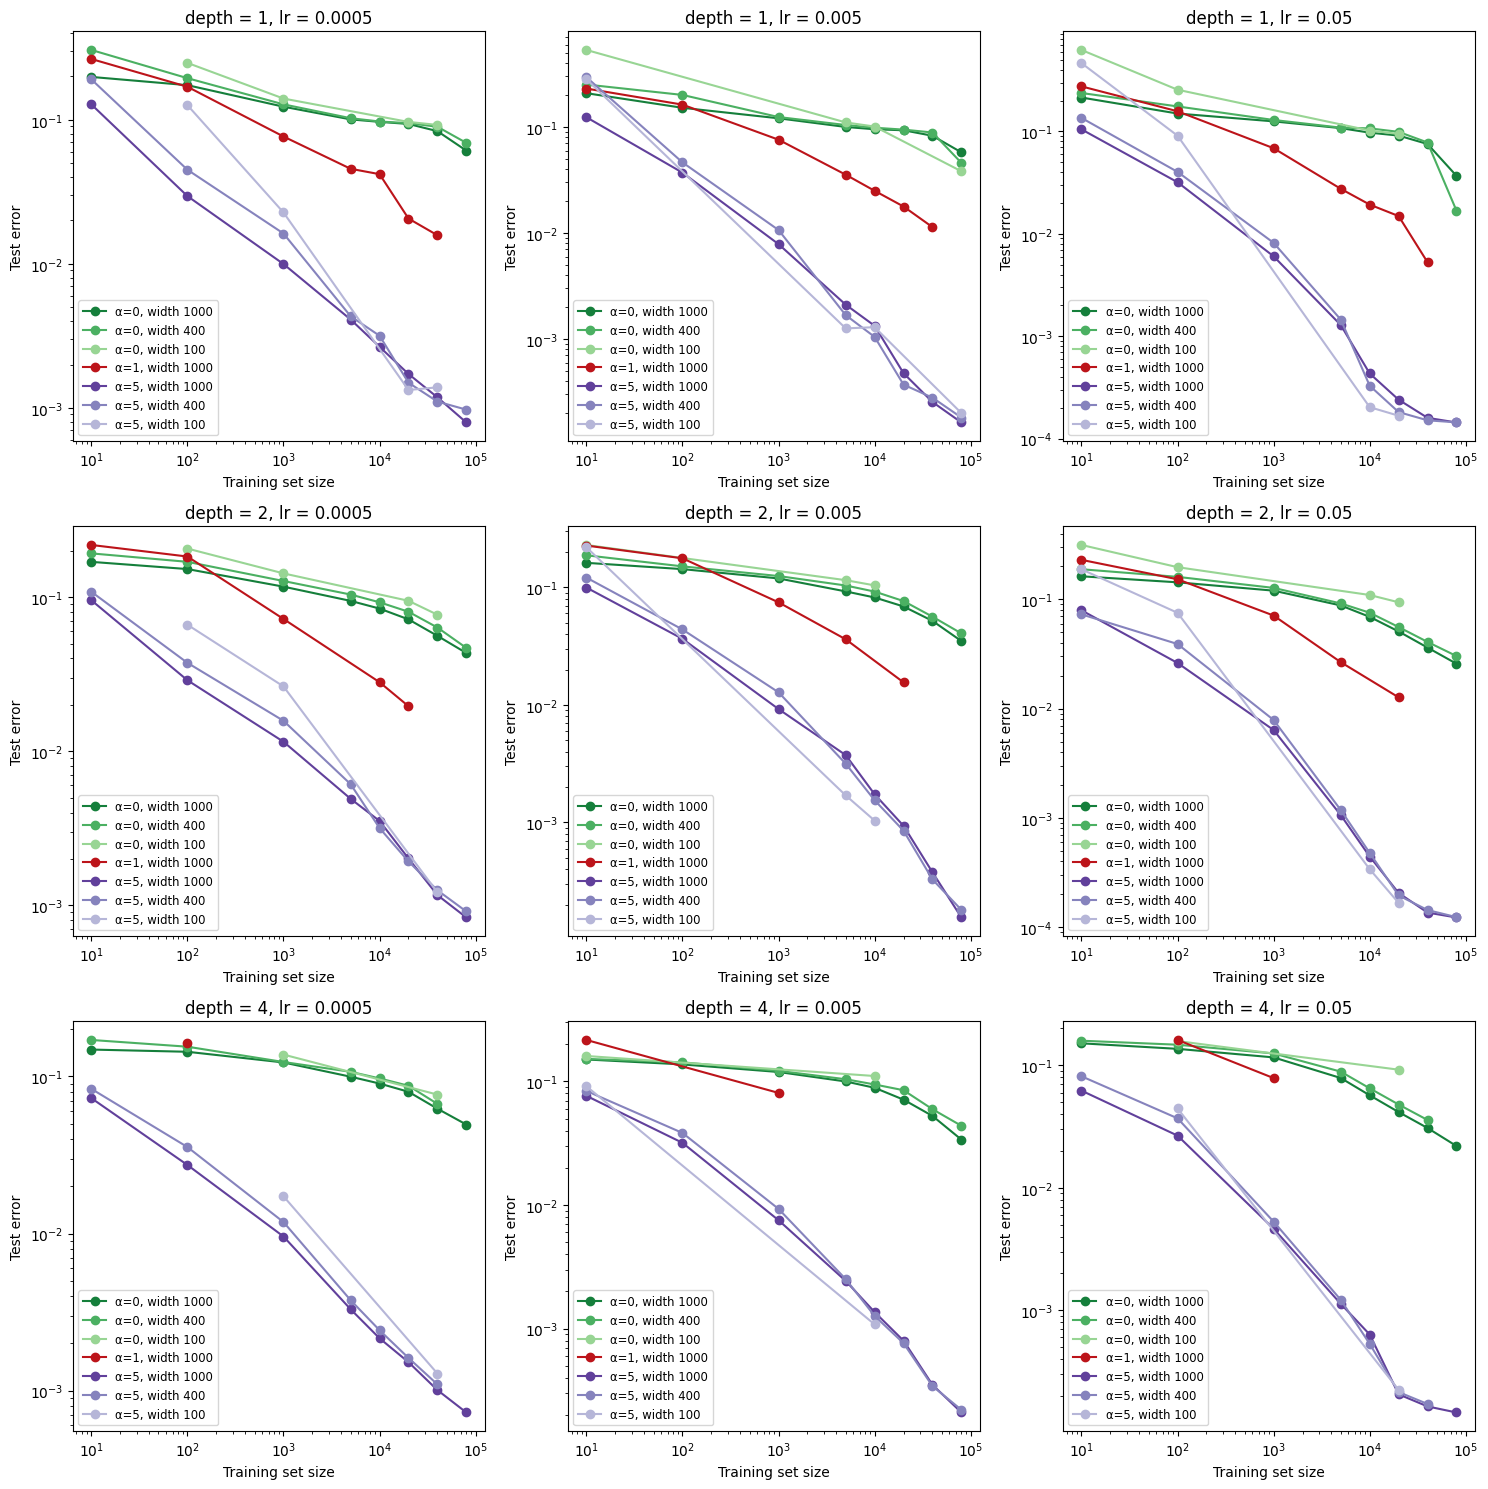

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_multiline_json_objects(filepath):
    """
    Load multiple JSON objects from a file with improved error handling
    """
    objects = []
    current_object = ""
    brace_count = 0
    
    with open(filepath, 'r') as f:
        for line in f:
            current_object += line
            brace_count += line.count('{') - line.count('}')
            
            if brace_count == 0 and current_object.strip():
                try:
                    obj = json.loads(current_object)
                    objects.append(obj)
                    current_object = ""
                except json.JSONDecodeError as e:
                    print(f"Warning: Skipping malformed JSON object: {e}")
                    current_object = ""
    
    return objects

def plot_multiple_alpha_results(results_dirs, alpha_names, alpha_colors):
    """
    Load and plot results from multiple directories with different alpha values.
    
    Args:
        results_dirs: List of directory paths containing result files
        alpha_names: List of names for each alpha value (e.g., ['α=0', 'α=1'])
        alpha_colors: List of base colors for each alpha value
    """
    # Store results for each alpha value
    all_results = []
    
    for results_dir in results_dirs:
        result_files = [
            os.path.join(results_dir, f)
            for f in os.listdir(results_dir)
            if f.startswith("results_") and f.endswith(".jsonl")
        ]
        
        results = []
        for filepath in result_files:
            try:
                with open(filepath, "r") as f:
                    for line in f:
                        if not line.strip():
                            continue
                        obj = json.loads(line)
                        results.append(obj)
            except json.JSONDecodeError:
                print(f"Falling back to multi-line JSON extraction for {filepath}")
                objs = load_multiline_json_objects(filepath)
                results.extend(objs)
        
        all_results.append([r for r in results if isinstance(r, dict)])

    # Create grouped data for each alpha value
    all_grouped = []
    for results in all_results:
        grouped = {}
        for res in results:
            depth = res.get("depth")
            lr = res.get("learning_rate")
            width = res.get("hidden_size")
            n_train = res.get("n_train")
            test_error = res.get("test_error")
            if None in (depth, lr, width, n_train, test_error):
                continue

            key = (depth, lr)
            if key not in grouped:
                grouped[key] = {}
            if width not in grouped[key]:
                grouped[key][width] = []
            grouped[key][width].append((n_train, test_error))
        all_grouped.append(grouped)

    # Get unique parameters across all results
    unique_depths = sorted(set().union(*[set(key[0] for key in group.keys()) for group in all_grouped]))
    unique_lrs = sorted(set().union(*[set(key[1] for key in group.keys()) for group in all_grouped]))
    
    all_widths = set()
    for grouped in all_grouped:
        for group in grouped.values():
            all_widths.update(group.keys())
    unique_widths = sorted(all_widths)

    # Create color maps for different widths within each alpha group
    n_widths = len(unique_widths)
    width_colors = {}
    for alpha_idx, base_color in enumerate(alpha_colors):
        cmap = plt.cm.get_cmap('Blues')
        width_colors[alpha_idx] = {}
        for i, width in enumerate(unique_widths):
            norm_val = 0.4 + 0.4 * (i / (n_widths - 1)) if n_widths > 1 else 0.6
            rgb = plt.cm.get_cmap(base_color)(norm_val)[:3]
            width_colors[alpha_idx][width] = rgb

    # Create grid of subplots
    n_rows = len(unique_depths)
    n_cols = len(unique_lrs)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False)

    for i, depth in enumerate(unique_depths):
        for j, lr in enumerate(unique_lrs):
            ax = axes[i][j]
            key = (depth, lr)
            
            for alpha_idx, (grouped, alpha_name) in enumerate(zip(all_grouped, alpha_names)):
                if key not in grouped:
                    continue
                    
                for width, data_points in grouped[key].items():
                    # Aggregate points by training set size
                    agg = {}
                    for nt, te in data_points:
                        agg.setdefault(nt, []).append(te)
                    n_trains_sorted = sorted(agg.keys())
                    avg_test_errors = [np.mean(agg[nt]) for nt in n_trains_sorted]
                    
                    ax.plot(
                        n_trains_sorted,
                        avg_test_errors,
                        marker='o',
                        color=width_colors[alpha_idx][width],
                        label=f"{alpha_name}, width {width}"
                    )
            
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_title(f"depth = {depth}, lr = {lr}")
            ax.set_xlabel("Training set size")
            ax.set_ylabel("Test error")
            ax.legend(fontsize='small', loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage (you'll need to provide the actual paths):
results_dirs = [
    "/mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=0_grid",
    "/mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=1_grid",
    "/mnt/users/goringn/generalization_022025/TF_setting/results_training/standard_alpha=5_grid"
]
alpha_names = ["α=0", "α=1", "α=5"]
alpha_colors = ['Greens', 'Reds', 'Purples']  # Color maps for each alpha value

plot_multiple_alpha_results(results_dirs, alpha_names, alpha_colors)

Falling back to multi-line JSON extraction for /home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=3.0_normalization/results_20250212_170741_rank22.jsonl
Falling back to multi-line JSON extraction for /home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=3.0_normalization/results_20250212_170741_rank19.jsonl
Falling back to multi-line JSON extraction for /home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=3.0_normalization/results_20250212_170741_rank15.jsonl
Falling back to multi-line JSON extraction for /home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=3.0_normalization/results_20250212_170741_rank23.jsonl
Falling back to multi-line JSON extraction for /home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=3.0_normalization/results_20250212_170741_rank18.jsonl
Falling back to multi-line JSON extraction for /home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=3.0_normalization/results_20250212_170741_rank1

/tmp/ipykernel_3787373/3310029459.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')
/tmp/ipykernel_3787373/3310029459.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgb = plt.cm.get_cmap(base_color)(norm_val)[:3]


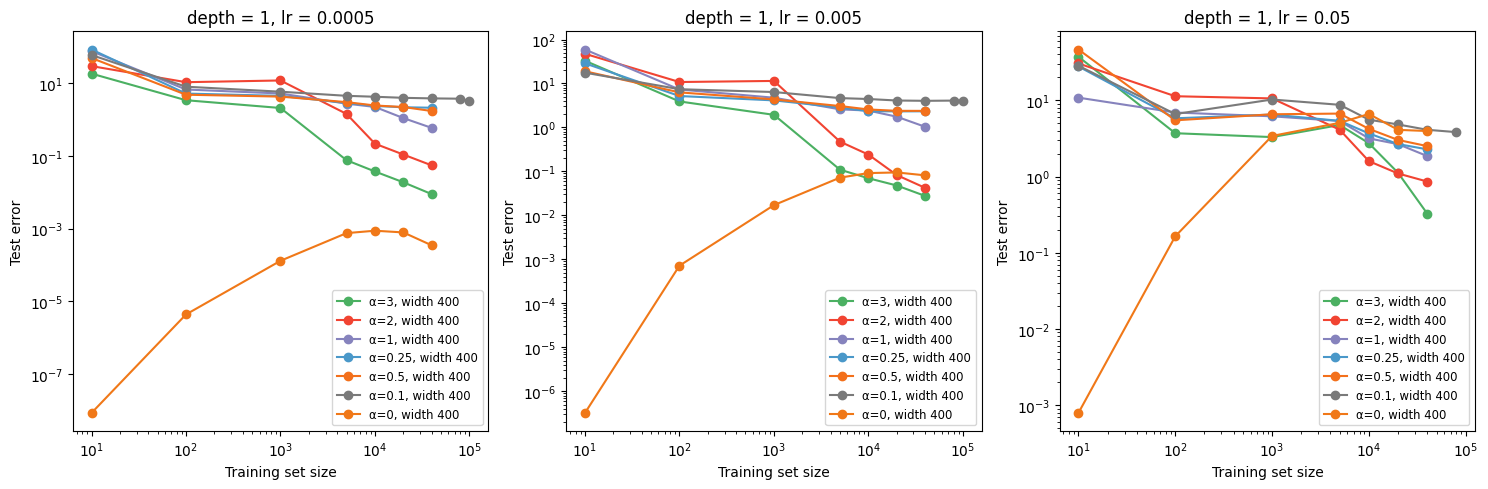

In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_multiline_json_objects(filepath):
    """
    Load multiple JSON objects from a file with improved error handling
    """
    objects = []
    current_object = ""
    brace_count = 0
    
    with open(filepath, 'r') as f:
        for line in f:
            current_object += line
            brace_count += line.count('{') - line.count('}')
            
            if brace_count == 0 and current_object.strip():
                try:
                    obj = json.loads(current_object)
                    objects.append(obj)
                    current_object = ""
                except json.JSONDecodeError as e:
                    print(f"Warning: Skipping malformed JSON object: {e}")
                    current_object = ""
    
    return objects

def plot_multiple_alpha_results(results_dirs, alpha_names, alpha_colors):
    """
    Load and plot results from multiple directories with different alpha values.
    
    Args:
        results_dirs: List of directory paths containing result files
        alpha_names: List of names for each alpha value (e.g., ['α=0', 'α=1'])
        alpha_colors: List of base colors for each alpha value
    """
    # Store results for each alpha value
    all_results = []
    
    for results_dir in results_dirs:
        result_files = [
            os.path.join(results_dir, f)
            for f in os.listdir(results_dir)
            if f.startswith("results_") and f.endswith(".jsonl")
        ]
        
        results = []
        for filepath in result_files:
            try:
                with open(filepath, "r") as f:
                    for line in f:
                        if not line.strip():
                            continue
                        obj = json.loads(line)
                        results.append(obj)
            except json.JSONDecodeError:
                print(f"Falling back to multi-line JSON extraction for {filepath}")
                objs = load_multiline_json_objects(filepath)
                results.extend(objs)
        
        all_results.append([r for r in results if isinstance(r, dict)])

    # Create grouped data for each alpha value
    all_grouped = []
    for results in all_results:
        grouped = {}
        for res in results:
            depth = res.get("depth")
            lr = res.get("learning_rate")
            width = res.get("hidden_size")
            n_train = res.get("n_train")
            test_error = res.get("test_error")
            if None in (depth, lr, width, n_train, test_error):
                continue

            key = (depth, lr)
            if key not in grouped:
                grouped[key] = {}
            if width not in grouped[key]:
                grouped[key][width] = []
            grouped[key][width].append((n_train, test_error))
        all_grouped.append(grouped)

    # Get unique parameters across all results
    unique_depths = sorted(set().union(*[set(key[0] for key in group.keys()) for group in all_grouped]))
    unique_lrs = sorted(set().union(*[set(key[1] for key in group.keys()) for group in all_grouped]))
    
    all_widths = set()
    for grouped in all_grouped:
        for group in grouped.values():
            all_widths.update(group.keys())
    unique_widths = sorted(all_widths)

    # Create color maps for different widths within each alpha group
    n_widths = len(unique_widths)
    width_colors = {}
    for alpha_idx, base_color in enumerate(alpha_colors):
        cmap = plt.cm.get_cmap('Blues')
        width_colors[alpha_idx] = {}
        for i, width in enumerate(unique_widths):
            norm_val = 0.4 + 0.4 * (i / (n_widths - 1)) if n_widths > 1 else 0.6
            rgb = plt.cm.get_cmap(base_color)(norm_val)[:3]
            width_colors[alpha_idx][width] = rgb

    # Create grid of subplots
    n_rows = len(unique_depths)
    n_cols = len(unique_lrs)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False)

    for i, depth in enumerate(unique_depths):
        for j, lr in enumerate(unique_lrs):
            ax = axes[i][j]
            key = (depth, lr)
            
            for alpha_idx, (grouped, alpha_name) in enumerate(zip(all_grouped, alpha_names)):
                if key not in grouped:
                    continue
                    
                for width, data_points in grouped[key].items():
                    # Aggregate points by training set size
                    agg = {}
                    for nt, te in data_points:
                        agg.setdefault(nt, []).append(te)
                    n_trains_sorted = sorted(agg.keys())
                    avg_test_errors = [np.mean(agg[nt]) for nt in n_trains_sorted]
                    
                    ax.plot(
                        n_trains_sorted,
                        avg_test_errors,
                        marker='o',
                        color=width_colors[alpha_idx][width],
                        label=f"{alpha_name}, width {width}"
                    )
            
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_title(f"depth = {depth}, lr = {lr}")
            ax.set_xlabel("Training set size")
            ax.set_ylabel("Test error")
            ax.legend(fontsize='small', loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage (you'll need to provide the actual paths):
results_dirs = [
    "/home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=3.0_normalization",
"/home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=2.0_normalization",
"/home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=1.0_normalization",
"/home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=0.25_normalization",
"/home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=0.5_normalization",
"/home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=0.1_normalization",
"/home/goring/TF_setting/train_results/mup_initalpha=0_targetalpha=0_nonormalization",
]
alpha_names = ["α=3","α=2","α=1", "α=0.25", "α=0.5", "α=0.1", "α=0"]
alpha_colors = ['Greens', 'Reds', 'Purples',"Blues", "Oranges","Greys","YlOrBr"]  # Color maps for each alpha value

plot_multiple_alpha_results(results_dirs, alpha_names, alpha_colors)

In [1]:
# %% [code]
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set style for seaborn plots.
sns.set(style="whitegrid")

def analyze_dataset(dataset_path):
    # Load the dataset
    print(f"\nLoading dataset from: {dataset_path}")
    data = torch.load(dataset_path, map_location='cpu')
    
    # Assume data is a dict with keys 'X' and 'y'
    X = data['X']
    y = data['y']
    
    # Convert to NumPy arrays for analysis
    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy().flatten()
    
    # Print basic shapes
    print("X shape:", X_np.shape)
    print("y shape:", y_np.shape)
    
    # Compute and print statistics for X
    print("\nStatistics for X (per feature):")
    print("  Mean:", np.mean(X_np, axis=0))
    print("  Std :", np.std(X_np, axis=0))
    print("  Min :", np.min(X_np, axis=0))
    print("  Max :", np.max(X_np, axis=0))
    
    # Compute and print statistics for y
    print("\nStatistics for y:")
    print("  Mean :", np.mean(y_np))
    print("  Std  :", np.std(y_np))
    print("  Min  :", np.min(y_np))
    print("  Max  :", np.max(y_np))
    percentiles = np.percentile(y_np, [0, 25, 50, 75, 100])
    print("  Percentiles (0,25,50,75,100):", percentiles)
    
    # Plot histogram of y
    plt.figure(figsize=(8, 4))
    sns.histplot(y_np, bins=50, kde=True)
    plt.title(f"Histogram of y from\n{os.path.basename(dataset_path)}")
    plt.xlabel("y")
    plt.ylabel("Frequency")
    plt.show()
    
    # Plot histograms for the first few features of X (up to 5)
    num_features_to_plot = min(5, X_np.shape[1])
    plt.figure(figsize=(12, 8))
    for i in range(num_features_to_plot):
        plt.subplot(2, 3, i+1)
        sns.histplot(X_np[:, i], bins=50, kde=True)
        plt.title(f"Feature {i} distribution")
        plt.xlabel(f"X[:, {i}]")
    plt.tight_layout()
    plt.show()
    
    # Compute and visualize the covariance eigenvalues of X
    cov_X = np.cov(X_np, rowvar=False)
    eigvals = np.linalg.eigvalsh(cov_X)
    print("\nEigenvalues of the covariance of X:")
    print(eigvals)
    
    plt.figure(figsize=(8, 4))
    plt.semilogy(eigvals, 'o-')
    plt.title("Eigenvalues of X Covariance Matrix")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue (log scale)")
    plt.show()
    
    # Scatter plot: Mean of features per sample vs y
    X_mean = np.mean(X_np, axis=1)
    plt.figure(figsize=(8, 4))
    plt.scatter(X_mean, y_np, alpha=0.5)
    plt.title("Scatter: Mean of X features vs y")
    plt.xlabel("Mean of X features")
    plt.ylabel("y")
    plt.show()
    
    return

# %% [code]
# List the dataset paths you want to analyze.
dataset_paths = [
    "/home/goring/TF_spectrum/results_pretrain_testgrid/results_model_d30_hidden256_depth1_alpha5.0_20250217_175123/dataset_model_d30_hidden256_depth1_alpha5.0_20250217_175123.pt",  # Replace with your actual file path.
    "/home/goring/TF_spectrum/results/results_2_model_d30_hidden400_depth1_alpha5.0_20250211_005109/dataset_model_d30_hidden400_depth1_alpha5.0_20250211_005109.pt"   # You can add more if needed.
]

for ds_path in dataset_paths:
    analyze_dataset(ds_path)


ModuleNotFoundError: No module named 'seaborn'


Loading dataset from: /home/goring/TF_spectrum/results_pretrain_testgrid/results_model_d30_hidden256_depth1_alpha5.0_20250217_175123/dataset_model_d30_hidden256_depth1_alpha5.0_20250217_175123.pt


/tmp/ipykernel_2773698/1170850302.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(dataset_path, map_location='cpu')


X shape: (300000, 30)
y shape: (300000,)

Statistics for X (per feature):
  Mean: [ 5.1508360e-03 -3.0777496e-04 -1.3265670e-03 -9.1844716e-04
 -9.3706744e-04 -1.4524307e-03 -1.3616423e-03  1.9920918e-03
 -2.0936613e-03  1.2488911e-03 -3.4460326e-04  5.1991001e-04
  1.1743843e-04  1.7811346e-03 -8.2511047e-04 -1.5255529e-03
 -5.7456532e-04  3.7792439e-04 -3.4328064e-04  1.8014569e-03
 -7.9658144e-05  2.2035665e-04 -1.6085907e-03 -4.1839777e-04
  1.7889526e-03 -1.1002764e-03  9.0405496e-04  1.1387480e-03
  4.9469252e-03  5.1760871e-04]
  Std : [1.0004524  0.9983341  0.99920493 0.9989946  1.001623   1.000747
 0.999432   1.0013882  1.0000321  1.0012091  0.9986458  0.99909234
 0.99920815 0.99965173 0.99971133 0.99888897 1.0023587  0.99852043
 0.99809337 1.0011095  0.9991294  0.9993223  1.0020783  1.002392
 0.9987696  1.0004426  1.0011026  1.0008937  0.99943507 1.0008658 ]
  Min : [-4.3037086 -4.517615  -4.7391896 -4.630633  -4.4560947 -4.580477
 -4.9850492 -4.410181  -4.298598  -4.585779  

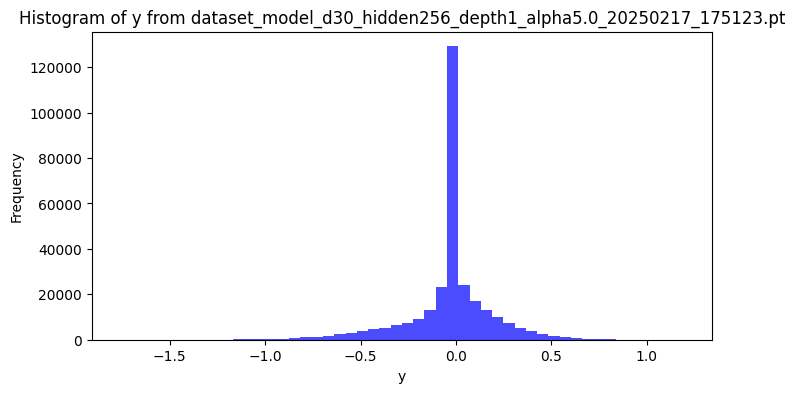

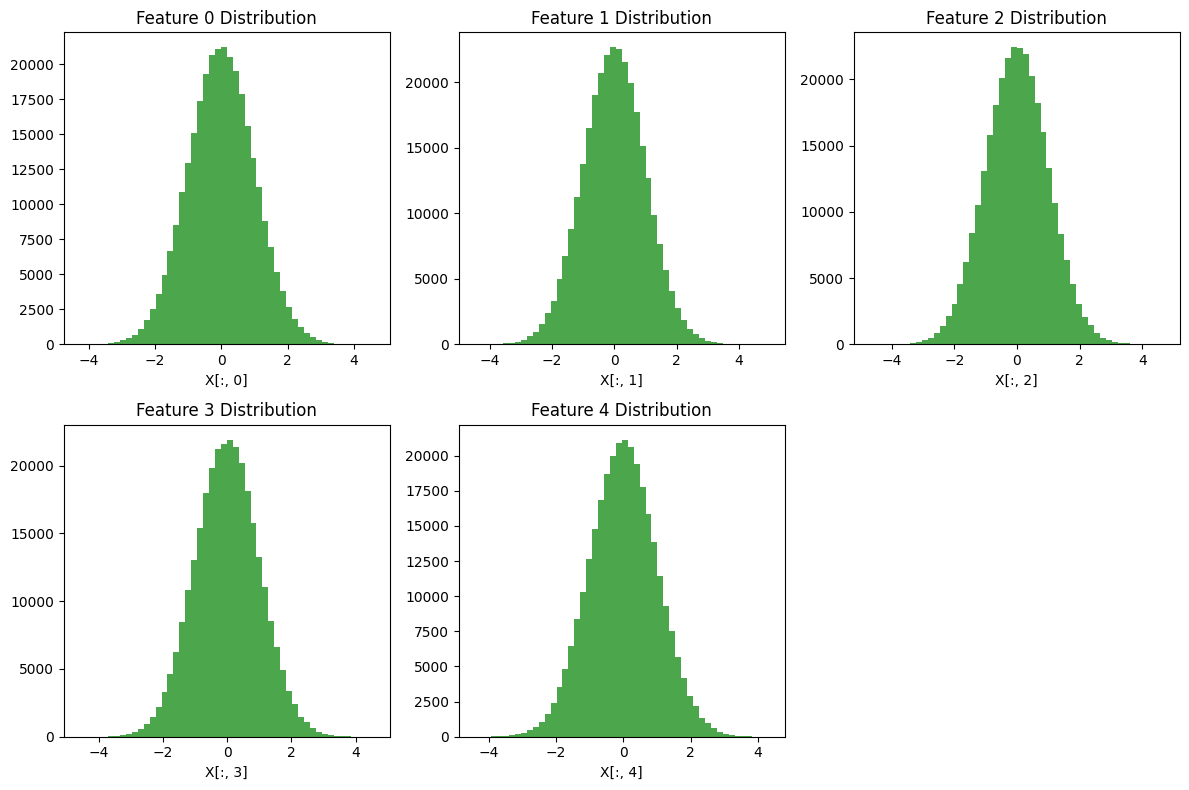


Eigenvalues of the covariance of X:
[0.9814777  0.98325666 0.98553366 0.98700362 0.98813128 0.98921669
 0.9904595  0.99211036 0.99255138 0.99341278 0.99531991 0.99631789
 0.99745056 0.99876223 0.99977054 1.00049258 1.00185682 1.00215469
 1.00450499 1.00621658 1.00693584 1.00773986 1.00876575 1.00957075
 1.01126681 1.01162386 1.01331662 1.01495451 1.0161148  1.01864625]


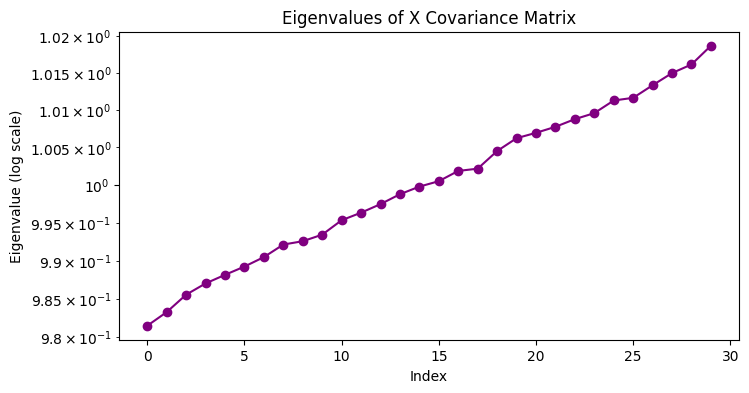

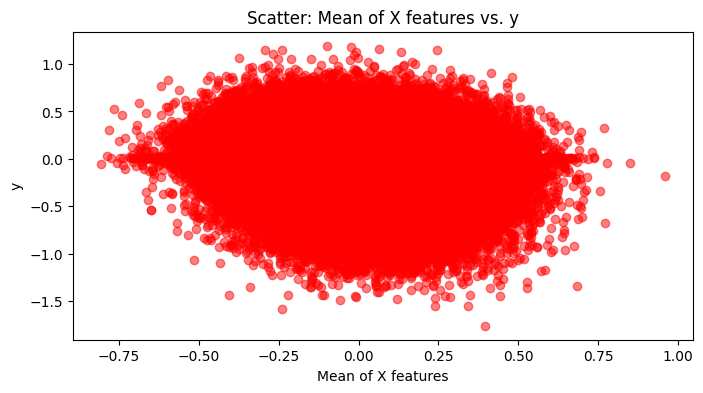


Loading dataset from: /home/goring/TF_spectrum/results/results_2_model_d30_hidden400_depth1_alpha5.0_20250211_005109/dataset_model_d30_hidden400_depth1_alpha5.0_20250211_005109.pt
X shape: (200000, 30)
y shape: (200000,)

Statistics for X (per feature):
  Mean: [-0.00157897 -0.00214424  0.00140654  0.00107938  0.00388604 -0.00358612
  0.00418097 -0.00115248 -0.00120783 -0.00022461 -0.00081672  0.00012348
  0.00087885  0.00244762  0.0051187  -0.00194276 -0.00251486  0.0011344
 -0.00186368  0.00121937  0.0023909  -0.00020626 -0.0022255  -0.00182065
  0.00020488  0.00173843  0.00180706  0.00097326 -0.0004319   0.0035458 ]
  Std : [0.99898124 0.99849457 0.99882364 1.0013214  0.99851066 1.0016605
 0.9974397  0.9991319  0.99531126 1.0029705  0.9991723  1.0018773
 0.9978439  1.002296   0.9986866  1.002341   1.0010527  0.9975821
 0.99915594 0.99965906 1.000068   0.99801    0.9984535  1.0019885
 1.0001338  1.0003746  1.0006669  1.0003002  0.99763477 0.9992843 ]
  Min : [-4.7849345 -4.7481847 -

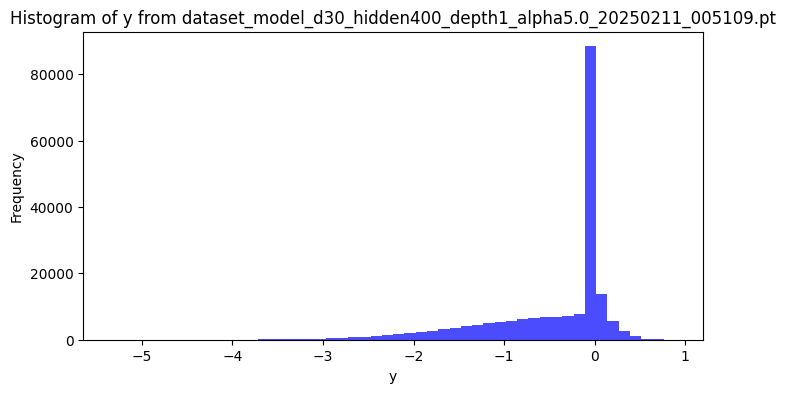

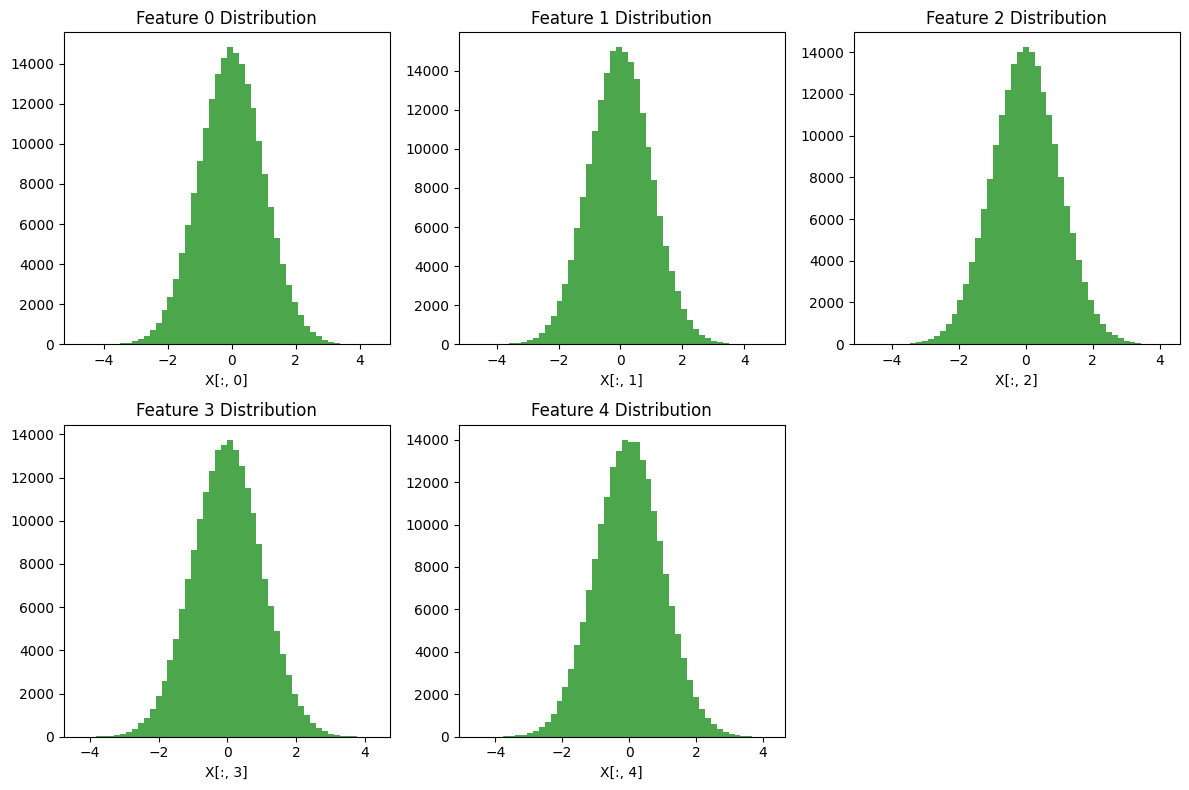


Eigenvalues of the covariance of X:
[0.97215622 0.97829777 0.98108454 0.98286146 0.98536671 0.98716623
 0.98805749 0.98993235 0.99049125 0.99236141 0.99348875 0.99505231
 0.99574414 0.99756176 0.99852661 0.99953716 1.0002968  1.00158477
 1.00360287 1.00499472 1.00619952 1.00660257 1.00791554 1.01277698
 1.01317104 1.01429408 1.01781638 1.01851138 1.01931395 1.02527695]


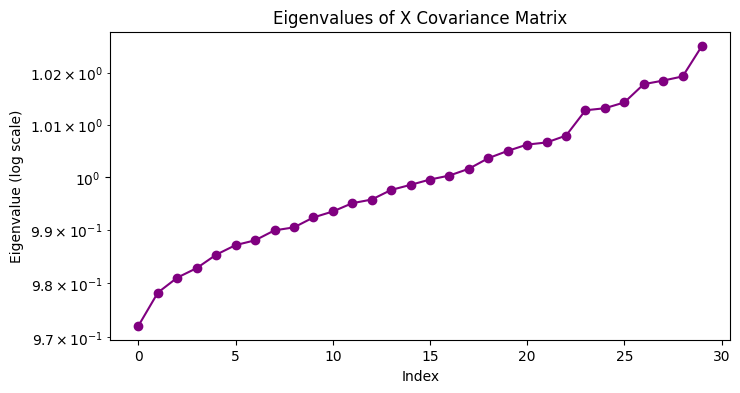

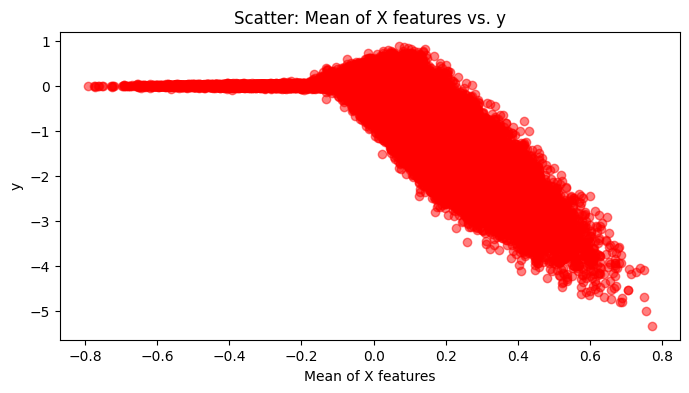

In [2]:
# %% [code]
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_dataset(dataset_path):
    # Load the dataset (assumes a dict with keys "X" and "y")
    print(f"\nLoading dataset from: {dataset_path}")
    data = torch.load(dataset_path, map_location='cpu')
    
    X = data['X']
    y = data['y']
    
    # Convert to NumPy arrays for analysis
    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy().flatten()
    
    # Print basic shapes
    print("X shape:", X_np.shape)
    print("y shape:", y_np.shape)
    
    # Compute and print per-feature statistics for X
    print("\nStatistics for X (per feature):")
    print("  Mean:", np.mean(X_np, axis=0))
    print("  Std :", np.std(X_np, axis=0))
    print("  Min :", np.min(X_np, axis=0))
    print("  Max :", np.max(X_np, axis=0))
    
    # Compute and print overall statistics for y
    print("\nStatistics for y:")
    print("  Mean :", np.mean(y_np))
    print("  Std  :", np.std(y_np))
    print("  Min  :", np.min(y_np))
    print("  Max  :", np.max(y_np))
    percentiles = np.percentile(y_np, [0, 25, 50, 75, 100])
    print("  Percentiles (0,25,50,75,100):", percentiles)
    
    # Plot histogram for y
    plt.figure(figsize=(8, 4))
    plt.hist(y_np, bins=50, color='blue', alpha=0.7)
    plt.title(f"Histogram of y from {os.path.basename(dataset_path)}")
    plt.xlabel("y")
    plt.ylabel("Frequency")
    plt.show()
    
    # Plot histograms for the first few features of X (up to 5)
    num_features_to_plot = min(5, X_np.shape[1])
    plt.figure(figsize=(12, 8))
    for i in range(num_features_to_plot):
        plt.subplot(2, 3, i+1)
        plt.hist(X_np[:, i], bins=50, color='green', alpha=0.7)
        plt.title(f"Feature {i} Distribution")
        plt.xlabel(f"X[:, {i}]")
    plt.tight_layout()
    plt.show()
    
    # Compute and visualize eigenvalues of the covariance matrix of X
    cov_X = np.cov(X_np, rowvar=False)
    eigvals = np.linalg.eigvalsh(cov_X)
    print("\nEigenvalues of the covariance of X:")
    print(eigvals)
    
    plt.figure(figsize=(8, 4))
    plt.semilogy(eigvals, 'o-', color='purple')
    plt.title("Eigenvalues of X Covariance Matrix")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue (log scale)")
    plt.show()
    
    # Scatter plot: mean of features per sample vs. y
    X_mean = np.mean(X_np, axis=1)
    plt.figure(figsize=(8, 4))
    plt.scatter(X_mean, y_np, alpha=0.5, color='red')
    plt.title("Scatter: Mean of X features vs. y")
    plt.xlabel("Mean of X features")
    plt.ylabel("y")
    plt.show()

# %% [code]
# Replace these with your actual dataset paths.
dataset_paths = [
    "/home/goring/TF_spectrum/results_pretrain_testgrid/results_model_d30_hidden256_depth1_alpha5.0_20250217_175123/dataset_model_d30_hidden256_depth1_alpha5.0_20250217_175123.pt",  # Replace with your actual file path.
    "/home/goring/TF_spectrum/results/results_2_model_d30_hidden400_depth1_alpha5.0_20250211_005109/dataset_model_d30_hidden400_depth1_alpha5.0_20250211_005109.pt"   # You can add more if needed.
]

for ds_path in dataset_paths:
    analyze_dataset(ds_path)
